In [7]:
import time
import torch
import os
import nltk
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [8]:
%matplotlib inline


In [9]:
ran_state = 42

current_dir = os.getcwd()
data_dir = f'{current_dir}/dataset'
dl_folder = f'{current_dir}/dataset/dl'
destination_folder = f'{current_dir}/results'
filenames = [
    'kant.txt', 
    'aristotle.txt', 
    'plato.txt', 
    'hume.txt',
    'nietzsche.txt'
    ]

[os.path.join(data_dir, file) for file in filenames]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [10]:
csv_file = 'sentences.csv'
data_csv = os.path.join(data_dir, csv_file)
philo_df = pd.read_csv(data_csv).sample(frac = 1)
# philo_df = philo_df.loc[philo_df.author=='Nietzsche']
philo_all_df = philo_df.copy()
philo_df = philo_df.iloc[:len(philo_df)//2]
philo_df = philo_df.reset_index()
philo_df.head()

,index,label,sentence,author,word_count,mean_word_length,stop_words_ratio,stop_words_count,ADJ_count,ADV_count,...,X_count,INTJ_count,CONJ_count,CCONJ_count,SCONJ_count,PROPN_count,NOUN_count,PRON_count,PART_count,VERB_count
0,5873,0,"For I first take the number 7, and, for the co...",Kant,68,3.84,60.29,41,0,5,...,0,0,0,2,1,0,18,4,1,6
1,86561,3,Of Practical Wisdom exerted upon a community t...,Aristotle,39,5.23,61.54,24,2,1,...,0,0,0,2,1,6,5,1,0,4
2,63769,2,: And we have admitted that a thing cannot be ...,Plato,19,4.47,68.42,13,0,0,...,0,0,0,2,1,0,3,2,1,3
3,40021,1,"Cospatric also, in despair of success, made h...",Hume,36,4.86,58.33,21,0,2,...,0,0,0,2,1,2,10,0,0,4
4,95585,4,"From German body, this self-lacerating?",Nietzsche,5,7.00,40.00,2,1,0,...,0,0,0,0,0,0,2,0,0,1


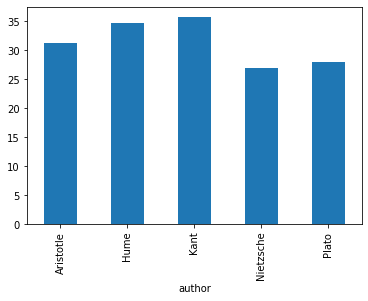

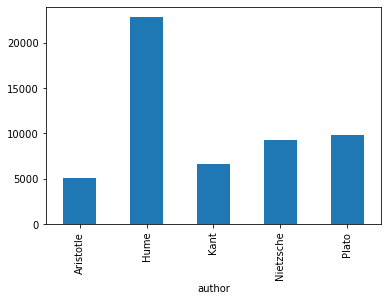

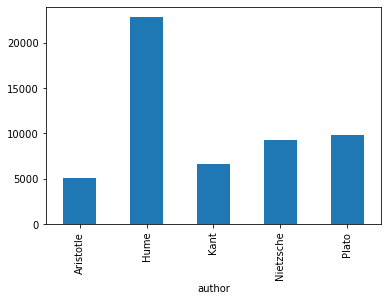

author
Aristotle    3
Hume         1
Kant         0
Nietzsche    4
Plato        2
Name: label, dtype: int64

In [11]:
df_nan = philo_df.isna()
# print(df_nan.sum())

# print(philo_df.describe())

philo_df['word_counter'] = philo_df['sentence'].apply(lambda x: x.count(' '))


philo_df.groupby('author')['word_count'].mean().plot.bar()
plt.show()
philo_df.groupby('author')['label'].count().plot.bar()
plt.show()

philo_df.groupby('author')['label'].size().plot.bar()
plt.show()

philo_df.groupby('author')['label'].mean()

In [12]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

first_n_words = 200

def trim_string(x):
    x = x.split(maxsplit=first_n_words)
    x = ' '.join(x[:first_n_words])
    return x

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
PATTERN_S = re.compile("\'s")
PATTERN_RN = re.compile("\\r\\n")
PATTERN_PUNC = re.compile(r"[^\w\s]")
STOPWORDS = set(stopwords.words('english'))
MIN_WORDS = 2

def clean_text(text):
    """
        text: a string
        # TODO What is doing spacy
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = re.sub(PATTERN_S, ' ', text)
    text = re.sub(PATTERN_RN, ' ', text)
    text = re.sub(PATTERN_PUNC, ' ', text)
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub(' ', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', ' ')
    text = re.sub(r'\W+', ' ', text)
    tokens = [w for w in text.split() if not w in STOPWORDS] # remove stopwors from text
    # Remove short words (under 3 characters) from the tokens
    long_words = []
    for token in tokens:
        if len(token) >= MIN_WORDS:
            long_words.append(token)
    # Join the tokens back together
    cleaned_text = (" ".join(long_words)).strip()
    return cleaned_text


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/bettyld/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
from nltk.stem.porter import *

# Processing the data
# Drop empty text
philo_df.drop(philo_df[philo_df.sentence.str.len()<3].index, inplace=True)

# To try
philo_df['clean_sentence'] = philo_df['sentence'].apply(clean_text)
philo_all_df['clean_sentence'] = philo_all_df['sentence'].apply(clean_text)
# trim 
# philo_df['trim_sentence'] = philo_df['sentence'].apply(trim_string)

philo_df['clean_sentence'] = philo_df['clean_sentence'].apply(lambda x: x.lower())
philo_df['sentence'] = philo_df['clean_sentence'].apply(lambda x: re.sub('[^A-Za-z0-9]+', ' ', x))

# # To try
# stemmer = PorterStemmer()
# philo_df["sentence"] = philo_df['stem_sentence'].str.split().apply(lambda x: ' '.join([stemmer.stem(w.lower()) for w in x]))

mini_philo_df = philo_df[['sentence', 'label']]


In [14]:
philo_df

,index,label,sentence,author,word_count,mean_word_length,stop_words_ratio,stop_words_count,ADJ_count,ADV_count,...,CONJ_count,CCONJ_count,SCONJ_count,PROPN_count,NOUN_count,PRON_count,PART_count,VERB_count,word_counter,clean_sentence
0,5873,0,first take number conception calling aid finge...,Kant,68,3.84,60.29,41,0,5,...,0,2,1,0,18,4,1,6,67,first take number conception calling aid finge...
1,86561,3,practical wisdom erted upon community would ca...,Aristotle,39,5.23,61.54,24,2,1,...,0,2,1,6,5,1,0,4,38,practical wisdom erted upon community would ca...
2,63769,2,admitted thing cannot taught neither teachers ...,Plato,19,4.47,68.42,13,0,0,...,0,2,1,0,3,2,1,3,18,admitted thing cannot taught neither teachers ...
3,40021,1,cospatric also despair success made peace king...,Hume,36,4.86,58.33,21,0,2,...,0,2,1,2,10,0,0,4,36,cospatric also despair success made peace king...
4,95585,4,german body self lacerating,Nietzsche,5,7.00,40.00,2,1,0,...,0,0,0,0,2,0,0,1,4,german body self lacerating
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53562,80689,3,sicily countries abundant supply goats milk mi...,Aristotle,41,4.46,60.98,25,3,4,...,0,3,2,1,9,6,1,3,40,sicily countries abundant supply goats milk mi...
53563,44959,1,besides taking oaths allegiance supremacy rece...,Hume,28,5.64,53.57,15,0,0,...,0,2,1,0,8,1,1,5,27,besides taking oaths allegiance supremacy rece...
53564,21344,1,bishop winchester care kings person education ...,Hume,64,5.00,56.25,36,6,0,...,0,7,1,1,18,4,1,3,64,bishop winchester care kings person education ...
53565,42216,1,king never content stated rents levied heavy t...,Hume,28,4.82,53.57,15,2,1,...,0,2,0,0,8,1,0,3,27,king never content stated rents levied heavy t...


In [17]:
import spacy
# !python -m spacy download en_core_web_lg

nlp = spacy.load("en_core_web_lg")

philo_df['spacy_sentence'] = philo_df['sentence'].apply(lambda x: nlp(x.lower())) # calling nlp on a string and spaCy tokenizes the text and creates a document object
philo_df['spacy_sentence_token'] = philo_df['sentence'].apply(lambda x: nlp(x.lower()).text.split()) # calling nlp on a string and spaCy tokenizes the text and creates a document object

# philo_all_df['spacy_sentence'] = philo_all_df['sentence'].apply(lambda x: nlp(x.lower())) # calling nlp on a string and spaCy tokenizes the text and creates a document object
philo_df['spacy_vec'] = philo_df['spacy_sentence'].apply(lambda x: np.array(x.vector))
philo_df['spacy_vec'] = philo_df['spacy_vec'].to_numpy()

In [75]:
pd.options.display.max_colwidth = 500


# Version 1
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


# Using TFIDF
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 3)) #one gram to three gram
tfidf_mat = vectorizer.fit_transform(philo_df['sentence'])
# Compute cosine similarity
cosine_sim_mat = cosine_similarity(tfidf_mat, tfidf_mat)
# cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

In [76]:
## Recommendation

# V1 tfidf recommandation matching

In [77]:
# print(tfidf_mat.shape) 
# print(cosine_sim_mat.shape)

def get_recommendations_v1(sentence, series):
    tokens = [str(tok) for tok in nlp(sentence)]
    # using tfidf
    vec = vectorizer.transform(tokens)
    # using spacy
#     print('computing similarity')
    mat = cosine_similarity(vec, tfidf_mat)
    best_sim_each_token = np.argmax(mat, axis=1)
    index = np.argsort(best_sim_each_token)[::-1] #take the five highest norm 
#     print('norms, indices', best_sim_each_token, index)
    null_index = best_sim_each_token != 0
    null_index = null_index[index]
    index = index[null_index==True]
    best_index = best_sim_each_token[index][:3]
#     print('best_index', best_index)
    print(philo_df[['sentence', 'author']].iloc[best_index])
    return best_index


mat = get_recommendations_v1('Can I eat a hot soup tonight?', philo_df['sentence'])


                                                                                           sentence  \
52923                                                                      conceal cold hot weather   
22104                                                                          also eat sweet fruit   
8007   soup meal meat boiled shreds vegetables cooked fat flour degeneration pastries paper weights   

          author  
52923  Aristotle  
22104  Aristotle  
8007   Nietzsche  


# V2 spacy vectors

In [30]:
def get_recommendations_v2(sentence, series):
    vec = np.array([tok.vector for tok in nlp(sentence)])
    print('computing similarity')
    data_vec = np.array([np.array(elt) for elt in philo_df['spacy_vec'].values])
    print(vec.shape, data_vec.shape)
    mat = cosine_similarity(vec, data_vec)
    best_sim_each_token = np.argmax(mat, axis=1)
    index = np.argsort(best_sim_each_token)[::-1] #take the five highest norm 
    print('norms, indices', best_sim_each_token, index)
    null_index = best_sim_each_token != 0
    null_index = null_index[index]
    index = index[null_index==True]
    best_index = best_sim_each_token[index][:3]
    print('best_index', best_index)
    print(philo_df[['sentence', 'author']].iloc[best_index])
    return best_index


mat = get_recommendations_v2('Can I eat a hot soup tonight?', philo_df['sentence'])


computing similarity
(8, 300) (2000, 300)
norms, indices [ 807 1420  648 1163 1735 1776  773  574] [5 4 1 3 0 6 2 7]
best_index [1776 1735 1420]
                                                                                                                                                                                                                                                                                             sentence  \
1776  adeps and fat differ from each other for fat is always brittle and coagulates upon cooling but adeps is liquid and does not coagulate and broths made from animals with adeps do not thicken as from the horse and hog but that made from animals with fat thickens as from the sheep and goat    
1735                                                                                                                                                                                                                     when the young are born the dam licks them i

# V3 Word2Vec

In [79]:
# Version #3 with word2vec gensim
# missing keys (common words)

from gensim.models import KeyedVectors
import gensim.downloader
import gensim.downloader as api

import nltk
nltk.download('punkt')

print(list(gensim.downloader.info()['models'].keys()))
# 'glove-wiki-gigaword-300'

# glove_vectors = gensim.downloader.load('word2vec-google-news-300')
glove_vectors = api.load('glove-wiki-gigaword-300')

[nltk_data] Downloading package punkt to /Users/bettyld/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [91]:
from gensim.models import Word2Vec

word2vec_model = Word2Vec(sentences=philo_df.spacy_sentence.values, vector_size=300, window=5, min_count = 1, workers = 2)
word2vec_model.build_vocab(philo_df.sentence.values)
print(word2vec_model.wv)
# word2vec_model.intersect_word2vec_format('./word2vec/GoogleNews-vectors-negative300.bin', lockf=0.0,binary=True)
word2vec_model.train(philo_df.sentence.values, total_examples=2, epochs = 2)
print(word2vec_model.wv)
word2vec_model.save('my_gensim_word2vec.bin')

In [104]:
# Access vectors for specific words with a keyed lookup:
# philo_df['gensim_vec'] = philo_df['spacy_sentence'].apply(lambda x: [word2vec_model.wv[elt.text] for elt in x])
print(philo_df.spacy_sentence.values)
print(word2vec_model.wv.key_to_index)
# word2vec_model = model.wv.get_vecattr("rock", "count")  # 👍
# word2vec_model = len(model.wv)  # 

[observe dionysius halicarnassus says regard ancient walls rome tent city appear greater athens must mean acropolis high town
 even earl derby rebelled pardoned restored fortune obliged pay seven years rent second time restored
 articles inquiry concerning conduct sheriffs henry promulgated 1170 show great power well licentiousness officers
 ... ioms properly relate quantities
 determination pure intuition obtain priori cognitions objects mathematics regards form phenomena whether ist things must intuited form thereby established
 thus still find whatever causes fluctuation mi ture passions degree uneasiness always produces fear least passion like scarcely distinguished]
{' ': 0, 'e': 1, 'n': 2, 'i': 3, 's': 4, 't': 5, 'r': 6, 'a': 7, 'o': 8, 'l': 9, 'd': 10, 'c': 11, 'u': 12, 'p': 13, 'm': 14, 'h': 15, 'g': 16, 'y': 17, 'f': 18, 'v': 19, 'b': 20, 'w': 21, 'k': 22, 'j': 23, 'q': 24, 'z': 25, '1': 26, '0': 27, '2': 28, '3': 29, '6': 30, '5': 31, '4': 32, '7': 33, '9': 34, '8': 35}


In [ ]:
def get_recommendations_v3(sentence, series):
    vec = [model[str(tok)] for tok in nlp(sentence)]
    print('computing similarity')
    mat = cosine_similarity(vec, philo_df['spacy_vec'].values)
    best_sim_each_token = np.argmax(mat, axis=1)
    index = np.argsort(best_sim_each_token)[::-1] #take the five highest norm 
    print('norms, indices', best_sim_each_token, index)
    null_index = best_sim_each_token != 0
    null_index = null_index[index]
    index = index[null_index==True]
    best_index = best_sim_each_token[index][:3]
    print('best_index', best_index)
    print(philo_df[['sentence', 'author']].iloc[best_index])
    return best_index

mat = get_recommendations_v3('I can\'t wait seeing you again', philo_df['sentence'])


In [ ]:
# Version 4 Doc2Vec
# import
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(philo_df['spacy_sentence'].values)]

# Training Doc2Vec
## Train doc2vec model
model = Doc2Vec(tagged_data, vector_size = 20, window = 2, min_count = 1, epochs = 100)


In [ ]:
print(tagged_data[0])
print(model.docvecs)

def get_recommendations_v4(sentence, series):
    print(sentence.split())
    vec = model.infer_vector(sentence.split())
    print('computing similarity')
    results = model.docvecs.most_similar(positive = [vec])
    best_idx, score = list(zip(*results))
    print(list(best_idx))
    print(philo_df[['sentence', 'author']].iloc[list(best_idx[:3])])
    
get_recommendations_v4('what is virtue?', philo_df['sentence'])


In [ ]:
# Version 5
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [ ]:
philo_df['bert_vec'] = philo_df['spacy_sentence'].apply(lambda x: sbert_model.encode(x.text))

def get_recommendations_v4(sentence, series):
    vec = model.encode([sentence])[0]
    print('computing similarity')
    mat = cosine_similarity(vec, philo_df['bert_vec'].values)
    best_sim_each_token = np.argmax(mat, axis=1)
    index = np.argsort(best_sim_each_token)[::-1] #take the five highest norm 
    print('norms, indices', best_sim_each_token, index)
    null_index = best_sim_each_token != 0
    null_index = null_index[index]
    index = index[null_index==True]
    best_index = best_sim_each_token[index][:3]
    print('best_index', best_index)
    print(philo_df[['sentence', 'author']].iloc[best_index])
    return best_index


In [ ]:
# V6 Torch bert transformers
import torch
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')    # Download vocabulary from S3 and cache.
model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'bert-base-uncased')    # Download model and configuration from S3 and cache.
# model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'bert-base-uncased', output_attentions=True)  # Update configuration during loading
# assert model.config.output_attentions == True


In [ ]:
text_1 = "Who was Jim Henson ?"
text_2 = "Jim Henson was a puppeteer"
indexed_tokens = tokenizer.encode(text_1, text_2, add_special_tokens=True)

# Convert inputs to PyTorch tensors
segments_tensors = torch.tensor([segments_ids])
tokens_tensor = torch.tensor([indexed_tokens])

model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'bert-base-cased')

with torch.no_grad():
    encoded_layers, _ = model(tokens_tensor, token_type_ids=segments_tensors)

In [ ]:
# Version 6 #infersen
# thank you https://www.analyticsvidhya.com/blog/2020/08/top-4-sentence-embedding-techniques-using-python/

In [ ]:
! mkdir encoder
! curl -Lo encoder/infersent2.pkl https://dl.fbaipublicfiles.com/infersent/infersent2.pkl
  
! mkdir GloVe
! curl -Lo GloVe/glove.840B.300d.zip http://nlp.stanford.edu/data/glove.840B.300d.zip
! unzip GloVe/glove.840B.300d.zip -d GloVe/

In [ ]:
from models import InferSent
import torch

V = 2
MODEL_PATH = 'encoder/infersent%s.pkl' % V
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': V}
model_infersen = InferSent(params_model)
model_infersen.load_state_dict(torch.load(MODEL_PATH))

W2V_PATH = '/content/GloVe/glove.840B.300d.txt'
model_infersen.set_w2v_path(W2V_PATH)

In [ ]:
model_infersen.build_vocab(philo_df['spacy_sentence'].values, tokenize=True)
infersen_mat = np.array([model.encode([sent])[0] for sent in philo_df['spacy_sentence']])

In [ ]:
def get_recommendations_v4(sentence, series):
    vec = model_infersen.encode([sentence])[0]
    print('computing similarity')
    mat = cosine_similarity(vec, infersen_mat)
    best_sim_each_token = np.argmax(mat, axis=1)
    index = np.argsort(best_sim_each_token)[::-1] #take the five highest norm 
    print('norms, indices', best_sim_each_token, index)
    null_index = best_sim_each_token != 0
    null_index = null_index[index]
    index = index[null_index==True]
    best_index = best_sim_each_token[index][:3]
    print('best_index', best_index)
    print(philo_df[['sentence', 'author']].iloc[best_index])
    return best_index